Version 1.0.0

# Introduction

In this programming assignment we will illustrate a very severe data leakage, that can often be found in competitions, where the pairs of object should be scored, e.g. predict $1$ if two objects belong to the same class and $0$ otherwise. 

The data in this assignment is taken from a real competition, and the funniest thing is that *we will not use training set at all* and achieve almost 100% accuracy score! We will just exploit the leakage.

Now go through the notebook and complete the assignment.

In [1]:
import numpy as np
import pandas as pd 
import scipy.sparse
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Load the data

Let's load the test data. Note, that we don't have any training data here, just test data. Moreover, *we will not even use any features* of test objects. All we need to solve this task is the file with the indices for the pairs, that we need to compare.

Let's load the data with test indices.

In [2]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


For example, we can think that there is a test dataset of images, and each image is assigned a unique `Id` from $0$ to $N-1$ (N -- is the number of images). In the dataframe from above `FirstId` and `SecondId` point to these `Id`'s and define pairs, that we should compare: e.g. do both images in the pair belong to the same class or not. So, for example for the first row: if images with `Id=1427` and `Id=8053` belong to the same class, we should predict $1$, and $0$ otherwise. 

But in our case we don't really care about the images, and how exactly we compare the images (as long as comparator is binary).  

**We suggest you to try to solve the puzzle yourself first.** You need to submit a `.csv` file with columns `pairId` and `Prediction` to the grader. The number of submissions allowed is made pretty huge to let you explore the data without worries. The returned score should be very close to $1$.

**If you do not want to think much** -- scroll down and follow the instructions below.

In [3]:
test.shape

(368550, 3)

In [4]:
test.describe()

,pairId,FirstId,SecondId
count,368550.000000,368550.000000,368550.000000
mean,184274.500000,10863.601118,11950.398882
std,106391.365192,7280.190939,7602.814820
min,0.000000,0.000000,0.000000
25%,92137.250000,4574.000000,5698.000000
50%,184274.500000,9886.000000,10512.000000
75%,276411.750000,16512.000000,18782.000000
max,368549.000000,26324.000000,26324.000000


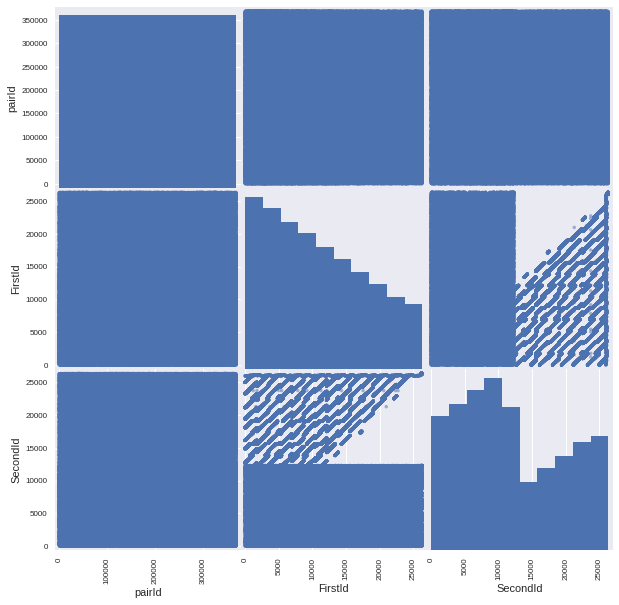

In [5]:
pd.plotting.scatter_matrix(test,figsize=(10,10))
plt.show()

Patricia's notes -------------- This tells us a few things:

pairId is evenly distributed across the range
FirstId and SecondId are not evenly distributed
There is definitely a relationship between FirstId and SecondId in part of the data
Let's look more closely at FirstId vs. SecondId
End notes ---------------------

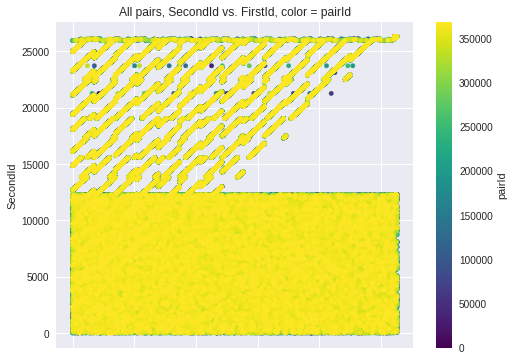

In [6]:
test.plot.scatter('FirstId','SecondId',c='pairId',figsize=(8,6), colormap='viridis')
plt.title('All pairs, SecondId vs. FirstId, color = pairId')
plt.show()

Arman's notes --------------
We've learned a bit more:

Since most data is yellow, the plot was likely populated homogenously, so it looks like the order of rows is random with respect to coordinate
I'm going to divide the distribution into two parts:
1) The bottom half "block"
2) The top half "lines"
A few questions to pursue:

What is the y-range of the "block"?
What fraction of the data is in the "block" vs. the "lines"?
Start with the first question
End notes ---------------------

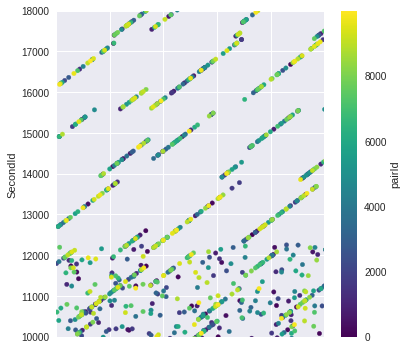

In [7]:
# What is the y-range of the "block"? Zoom in on the plot
test.iloc[0:10000].plot.scatter('FirstId','SecondId',c='pairId',
                  figsize=(6,6), 
                  colormap='viridis');
plt.xlim([0,5000]);
plt.ylim([10000,18000])
plt.show()

Arman's notes --------------
I'm going to approximate the y-cutoff as 12250. Continue with the next question: What fraction of the data is in the "block" vs. the "lines"?

I'm going to divide the SecondId vs. FirstId up into eight wedges.
End notes ---------------------

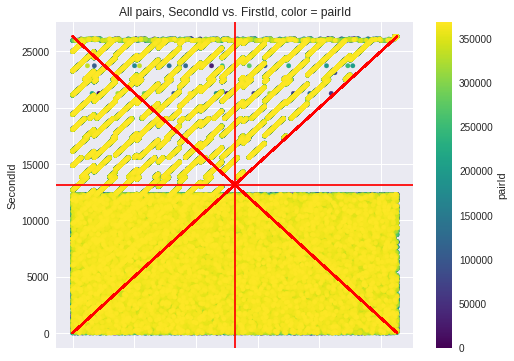

In [8]:
test.plot.scatter('FirstId','SecondId',c='pairId',
                  figsize=(8,6), 
                  colormap='viridis');
plt.axhline(test['FirstId'].max()/2,color='r');
plt.axvline(test['FirstId'].max()/2,color='r');
plt.plot(test['FirstId'],test['FirstId'],'r');
plt.plot(test['FirstId'],test['FirstId'].max()-test['FirstId'],'r');
plt.title('All pairs, SecondId vs. FirstId, color = pairId')
plt.show()

Arman's notes --------------
Let's approximate that the "block" distribution fills the space up to the horizontal line. Then we approximate the following number of events in each wedge.

Bottom four wedges: Each contains 1/4 of the block, and the left wedge contains 1/4 of the lines.
The three left wedges on top: Each contains 1/4 of the lines.
Let's follow the suggestions to use leaderboard probing to learn some more.
End notes ---------------------

# EDA and leakage intuition

As we already know, the key to discover data leakages is careful EDA. So let's start our work with some basic data exploration and build an intuition about the leakage.

First, check, how many different `id`s are there: concatenate `FirstId` and `SecondId` and print the number of unique elements. Also print minimum and maximum value for that vector.

In [9]:
# YOUR CODE GOES HERE
Id = pd.concat([test['FirstId'], test['SecondId']])

print('Number of unique pairs: {}'.format(Id.nunique()))
print('min:                    {}'.format(Id.min()))
print('max:                    {}'.format(Id.max()))

Number of unique pairs: 26325
min:                    0
max:                    26324


and then print how many pairs we need to classify (it is basically the number of rows in the test set)

In [10]:
# YOUR CODE GOES HERE
print('Size of test dataset: {:,}'.format(len(test)))

Size of test dataset: 368,550


Now print, how many distinct pairs it would be possible to create out of all "images" in the dataset?   

In [11]:
# YOUR CODE GOES HERE
print('Combinations of test dataset: {:,}'.format(len(test) ** 2))

Combinations of test dataset: 135,829,102,500


So the number of pairs we are given to classify is very very small compared to the total number of pairs. 

To exploit the leak we need to **assume (or prove)**, that the total number of positive pairs is small, compared to the total number of pairs. For example: think about an image dataset with $1000$ classes, $N$ images per class. Then if the task was to tell whether a pair of images belongs to the same class or not, we would have $1000\frac{N(N-1)}{2}$ positive pairs, while total number of pairs was $\frac{1000N(1000N - 1)}{2}$.

Another example: in [Quora competitition](https://www.kaggle.com/c/quora-question-pairs) the task was to classify whether a pair of qustions are duplicates of each other or not. Of course, total number of question pairs is very huge, while number of duplicates (positive pairs) is much much smaller.

Finally, let's get a fraction of pairs of class `1`. We just need to submit a constant prediction "all ones" and check the returned accuracy. Create a dataframe with columns `pairId` and `Prediction`, fill it and export it to `.csv` file. Then submit to grader and examine grader's output. 

In [12]:
# YOUR CODE GOES HERE
from collections import OrderedDict
pred = np.ones(len(test))

submission = pd.DataFrame(OrderedDict({'pairId': test.pairId,
                                      'Prediction': pred}))

submission.to_csv('submission.csv', index=False)

In [13]:
from IPython.display import display

display(submission.head())
print()
!head 'submission.csv'

,pairId,Prediction
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0



pairId,Prediction
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0


So, we assumed the total number of pairs is much higher than the number of positive pairs, but it is not the case for the test set. It means that the test set is constructed not by sampling random pairs, but with a specific sampling algorithm. Pairs of class `1` are oversampled.

Now think, how we can exploit this fact? What is the leak here? If you get it now, you may try to get to the final answer yourself, othewise you can follow the instructions below.   

Arman's notes --------------
We learned that half of the test data should be Prediction=1, the other half should be Prediction=0. That is a much higher ratio than in the original dataset, assuming that the fraction of pairs is actually 1/1000.

It looks like the organizers took a chunk of True pairs and then randomly generated False pairs in the same quantity. The False pairs were generated all with SecondId < 12250.

My guess is that the pairs in the lines are the True pairs, and the pairs in the block are the False pairs. I can test this theory by producing another submission, where all samples with SecondId > 12250 are 1 and SecondID < 12250 are 0.

I expect this to get a score around 0.875, because it should accurately classify all of the block pairs (which is half of the data), and three of the four wedges' worth of line pairs. The lower left wedge of line pairs will be set to 0 when they should really be 1.

Let's try it out.
End notes ---------------------

In [14]:
# Try with SecondId > 12250 true
mask = test['SecondId'] > 12250

In [15]:
submit = pd.DataFrame(test['pairId'])
print(submit.head())
submit['Prediction'] = 0
submit.loc[mask,'Prediction'] = 1
print(submit.head(10))

   pairId
0       0
1       1
2       2
3       3
4       4
   pairId  Prediction
0       0           0
1       1           0
2       2           1
3       3           1
4       4           0
5       5           1
6       6           0
7       7           0
8       8           0
9       9           0


In [16]:
submit.to_csv('above_12250.csv',index=False) # Score = 0.897954

Arman's notes --------------
That's pretty good. It's not exactly 0.875 like I had predicted. Why not? Let's look at where our y-cutoff is.
End notes ---------------------

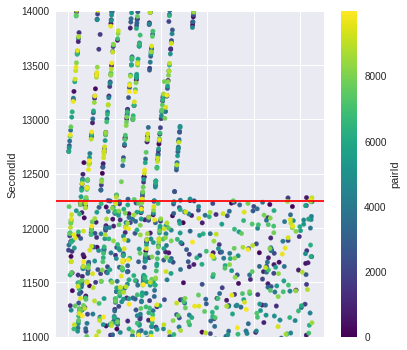

In [17]:
# What is the y-range of the "block"? Zoom in on the plot
test.iloc[0:10000].plot.scatter('FirstId','SecondId',c='pairId',
                  figsize=(6,6), 
                  colormap='viridis');
plt.axhline(12250,c='r')
plt.ylim([11000,14000])
plt.show()

Arman's notes --------------
It looks like my limit is a little low, so I am cutting off the block data a bit. I'm going to move the limit up and see if I can improve the score.
End notes ---------------------

In [18]:
# Closer look, be more precise with 12300
mask = test['SecondId'] > 12300
submit = pd.DataFrame(test['pairId'])
print(submit.head())
submit['Prediction'] = 0
submit.loc[mask,'Prediction'] = 1
print(submit.head(10))
submit.to_csv('above_12300.csv',index=False) # Score = 0.898443, captured a few more!

   pairId
0       0
1       1
2       2
3       3
4       4
   pairId  Prediction
0       0           0
1       1           0
2       2           1
3       3           1
4       4           0
5       5           1
6       6           0
7       7           0
8       8           0
9       9           0


Arman's notes --------------
Alright, it went up a little bit, but nothing significant. We can leave this y-cutoff at 12300. Let's go back to the main issue at hand...

The last chunk of data that is misclassified is the line points in the lower left wedge. How can we identify these points among the block noise? Find a way to identify points on lines. This is going to be more challenging.

Spend some time looking at the lines. What are the equations?
End notes ---------------------

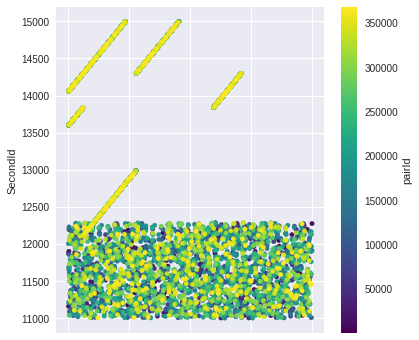

In [19]:
mask = ((test['FirstId'] > 11000) & (test['FirstId'] < 15000)) & (
        (test['SecondId'] > 11000) & (test['SecondId'] <15000))

test[mask].plot.scatter('FirstId','SecondId',c='pairId',
                  figsize=(6,6), 
                  colormap='viridis')
plt.show()

Arman's notes --------------
I spent some time manually going through a handful of lines to determine their equation. All of them fit the following equation:

SecondId = FirstId + $b$

Where $b$ is a constant value. Sometimes, the lines drift a bit across a few $b$ values so that each line doesn't have a perfect slope of 1.

How can I pull out points along a given line? One option is to search for all points which fit the above equation for a given value of $b$. I will scan through all possible $b$ values and see which ones have a lot of points on their line.

Looking at the early plots, the $b$ values may take any values in the range of SecondId or FirstId (they have the same range). Let's begin.
End notes ---------------------

In [20]:
# It looks like we are dealing with diagonal lines. What are the y-intercepts?
# Scan through all possible y-intercepts, look for points on line with m=1
b_to_try = np.arange(27000)
b_num_on_line = np.zeros(27000)

In [ ]:
for i in np.arange(len(b_to_try)):
    b = b_to_try[i]
    b_num_on_line[i] = sum(test['FirstId'] + b == test['SecondId'])

In [ ]:
# That took forever to compute, so save these to file so I don't have to repeat it
np.savetxt("b_num_on_line.csv", b_num_on_line, delimiter=",")
np.savetxt("b_to_try.csv", b_to_try, delimiter=",")

In [ ]:
# Look at distribution of `b_on_line` data. What is the threshold between background noise and "real" lines?
print(b_to_try.shape)
print(b_num_on_line.shape)

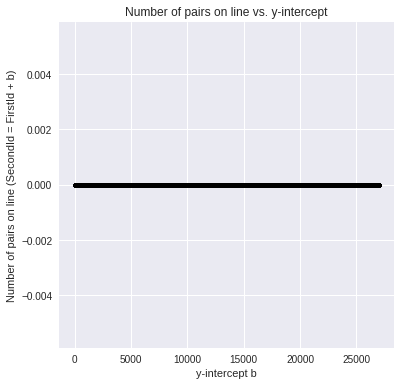

In [21]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(b_to_try,b_num_on_line,color='k',marker='.')
ax.set_xlabel('y-intercept b')
ax.set_ylabel('Number of pairs on line (SecondId = FirstId + b)')
ax.set_title('Number of pairs on line vs. y-intercept')
plt.show()

Arman's notes --------------
This looks pretty good. I can work with this. I need to take a closer look at the low numbers.

I expect any line with $b&gt;12300$ to not have any background because the lines that are that high up start with y-intercept above the block. Look at how the number of pairs changes vs. $b$, close up on the y-axis.
End notes ---------------------

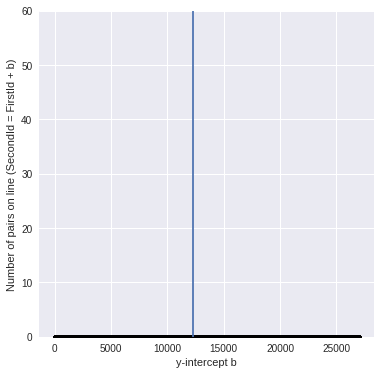

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(b_to_try,b_num_on_line,color='k',marker='.')
ax.axvline(12300)
ax.set_xlabel('y-intercept b')
ax.set_ylabel('Number of pairs on line (SecondId = FirstId + b)')
ax.set_ylim([0,60])
plt.show()

Arman's notes --------------
This fits with my previous theory. Now we need to decide, what number of pairs on a line are significant enough to indicate the presence of a line, vs. just a bunch of random points along the line? Look at some distributions, binned into histograms.
End notes ---------------------

In [23]:
b_bin_width = 200
b_range_limits = np.arange(380,12400,b_bin_width)
print(b_range_limits)
print(len(b_range_limits))

[  380   580   780   980  1180  1380  1580  1780  1980  2180  2380  2580
  2780  2980  3180  3380  3580  3780  3980  4180  4380  4580  4780  4980
  5180  5380  5580  5780  5980  6180  6380  6580  6780  6980  7180  7380
  7580  7780  7980  8180  8380  8580  8780  8980  9180  9380  9580  9780
  9980 10180 10380 10580 10780 10980 11180 11380 11580 11780 11980 12180
 12380]
61


In [24]:
for b_range_index in [0,2,5,10,20]:
    b_range_min = b_range_limits[b_range_index];
    b_range_max = b_range_limits[b_range_index+1];
    
    b_bin_mask = (b_to_try >= b_range_min) & (b_to_try < b_range_max)    
    b_num_mean = np.mean(b_num_on_line[b_bin_mask])
    b_num_std = np.sqrt(np.var(b_num_on_line[b_bin_mask]))
    print(b_num_mean,b_num_std)

    # Zoom in on lower data
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1,2,1)
    ax1.scatter(b_to_try[b_bin_mask],b_num_on_line[b_bin_mask],color='k',marker='.')
    ax1.set_xlabel('y-intercept b')
    ax1.set_ylabel('Number of pairs on line (SecondId = FirstId + b)')
    ax1.set_title('b in range {} to {}'.format(b_range_min,b_range_max))
    ax1.set_ylim([0,200])
    
    ax2 = plt.subplot(1,2,2)
    ax2.hist(b_num_on_line[b_bin_mask],bins=np.arange(100))
    ax2.axvline(20)
    ax2.set_xlabel('Number of pairs on line (SecondId = FirstId + b)')
    ax2.set_ylabel('Counts')
    ax2.set_title('b in range {} to {}'.format(b_range_min,b_range_max))

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [25]:
mask_above_20 = b_num_on_line > 20;
b_above_20    = b_to_try[mask_above_20]
print(len(b_above_20))

0


In [26]:
np.savetxt("b_above_20.csv", b_above_20, delimiter=",")

Arman's notes --------------
I put the vertical line at 20 pairs. If a $b$ value has 20 or more pairs on its line, consider it a "real" line.

I think that I could actually move this limit down a bit, especially if I made the limit vary with $b$, but that would take some time. I'm going to try to submit the solution with a simple cut at 20 and see if that's enough to pass.

Steps in generating my solution:
1) First, fill everything above 12300 as 1
2) Second, fill everything below 12300 as 0 (I already completed steps 1 and 2 above)
3) Go back through everything below 12300 and identify points on a line. Change those to 1.
End notes ---------------------

In [27]:
# First and second, fill everything above 12300 as 1, below as 0
mask = test['SecondId'] > 12300
submit = pd.DataFrame(test['pairId'])
submit['Prediction'] = 0
submit.loc[mask,'Prediction'] = 1
print(submit.head(10))

   pairId  Prediction
0       0           0
1       1           0
2       2           1
3       3           1
4       4           0
5       5           1
6       6           0
7       7           0
8       8           0
9       9           0


In [28]:
sum(submit['Prediction'])

146846

In [29]:

# Scan through the entries with `Prediction` == 0 and see if it is on a line. If so, flip to 1
# This takes freaking forever by the way so don't repeat unless necessary
mask = submit['Prediction'] == 0
for index in submit[mask].index.values:
    if test.loc[index,'SecondId']-test.loc[index,'FirstId'] in b_above_20:
        # Flip 0 to 1
        submit.loc[index,'Prediction'] = 1
sum(submit['Prediction'])

146846

In [32]:
# Reload submit dataframe later so I don't have to regenerate it
#submit.head()

Arman's notes --------------
We see that the number of 1s in the submit DataFrame went up-- those were the points on lines in the lower left wedge that we identified and flipped to 1.

Can we visualize the result? Try plotting it.
End notes ---------------------

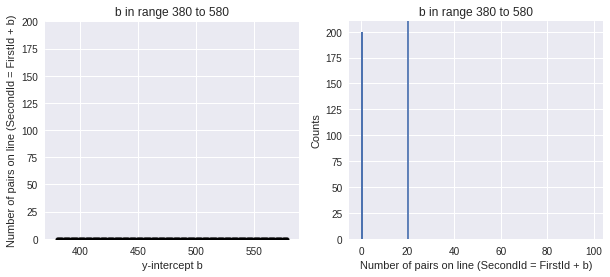

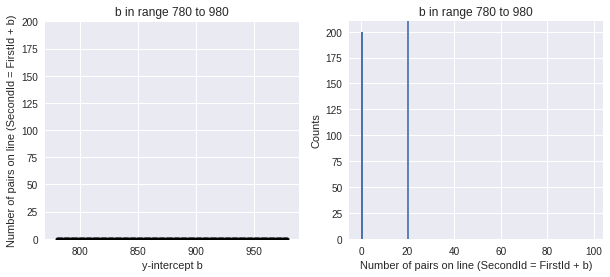

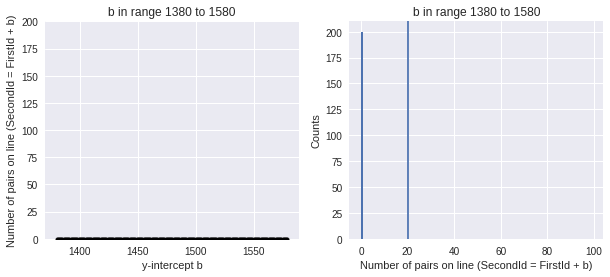

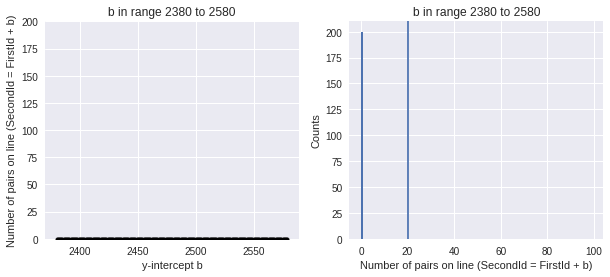

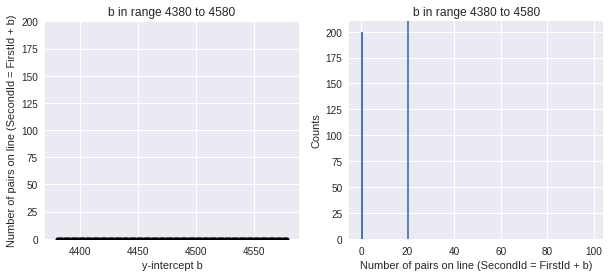

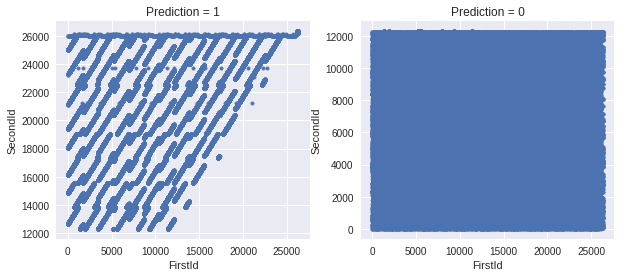

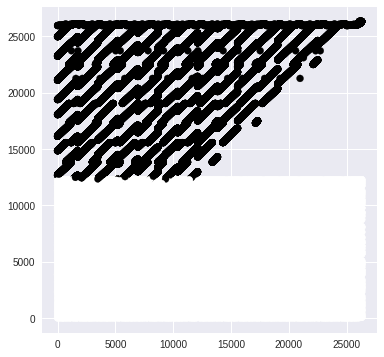

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(test['FirstId'],test['SecondId'],c=submit['Prediction'])
plt.show()

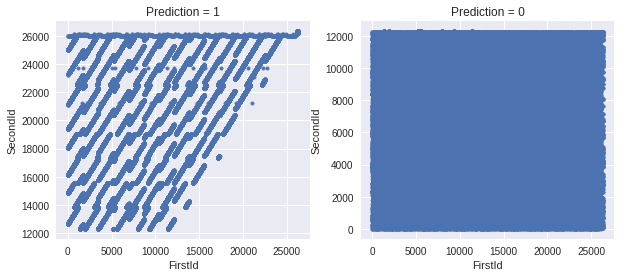

In [34]:
# Zoom in on lower data
mask_1 = submit['Prediction'] == 1

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
ax1.scatter(test.loc[mask_1,'FirstId'],test.loc[mask_1,'SecondId'],marker='.')
ax1.set_xlabel('FirstId')
ax1.set_ylabel('SecondId')
ax1.set_title('Prediction = 1')

ax2 = plt.subplot(1,2,2)
ax2.scatter(test.loc[~mask_1,'FirstId'],test.loc[~mask_1,'SecondId'],marker='.')
ax2.set_xlabel('FirstId')
ax2.set_ylabel('SecondId')
ax2.set_title('Prediction = 0')
plt.show()

Arman's notes --------------
This method is not foolproof, and it looks like we picked up a lot of the random points from the block data in our lines. Well, let's see if this was enough to pass the assignment.

If I wanted to improve this in the future, I would only scan through the lower left wedge when I pick the significant $b$ values and pull out the points on the line later.
End notes ---------------------

In [35]:
submit.to_csv('above_12300_with_slope_01.csv',index=False) # Score 0.991325 ... I win!

Arman's notes --------------
A score of 0.991325! Nice!

Less than 1% of data is misclassified. This is enough to pass the grader. Let's look at what the course organizers recommended we do.
End notes ---------------------

Arman's notes --------------
Try improving my score. Adjust my steps:

0) Regenerate the $b$ values above twenty. Redo all of that for data only in the lower left wedge.
1) First, fill everything above 12300 as 1
2) Second, fill everything below 12300 as 0 (I already completed steps 1 and 2 above)
3) Go back through everything in the lower left wedge identify points on a line. Change those to 1.
End notes ---------------------

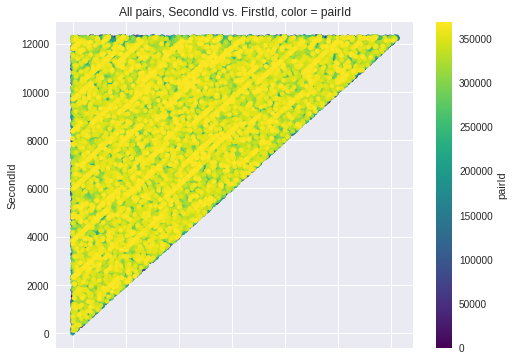

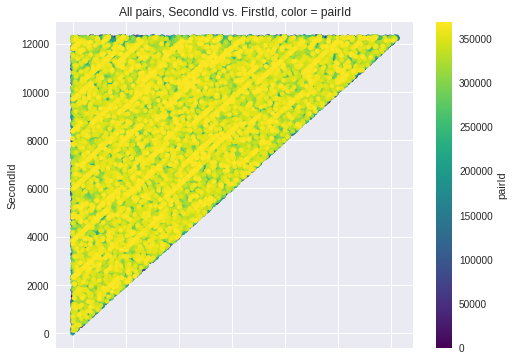

In [37]:
# First create a `test` dataframe with just the lower left wedge. Conditions are:
#    `SecondId` < 12300
#    `SecondId` > `FirstId`
mask_ll = (test['SecondId'] < 12300) & (test['SecondId'] > test['FirstId'])
test_ll = test[mask_ll]
# Plot to make sure it looks good
test_ll.plot.scatter('FirstId','SecondId',c='pairId',
                  figsize=(8,6), 
                  colormap='viridis');
plt.title('All pairs, SecondId vs. FirstId, color = pairId')
plt.show()

In [ ]:
# Only need to try b values in lower left wedge
b_to_try_ll = np.arange(12300)
b_num_on_line_ll = np.zeros(12300)

for i in tqdm(np.arange(len(b_to_try_ll))):
    b = b_to_try_ll[i]
    b_num_on_line_ll[i] = sum(test_ll['FirstId'] + b == test_ll['SecondId'])

In [ ]:
# That took not as forever to compute.
np.savetxt("b_num_on_line_ll.csv", b_num_on_line_ll, delimiter=",")
np.savetxt("b_to_try_ll.csv", b_to_try_ll, delimiter=",")
# Look at distribution of `b_on_line` data. What is the threshold between background noise and "real" lines?
print(b_to_try_ll.shape)
print(b_num_on_line_ll.shape)

In [ ]:
fig = plt.figure(figsize=(6,4));
ax = fig.gca();
ax.scatter(b_to_try_ll,b_num_on_line_ll,color='k',marker='.');
ax.set_xlabel('y-intercept b');
ax.set_ylabel('Number of pairs on line (SecondId = FirstId + b)');
ax.set_title('Number of pairs on line vs. y-intercept- lower left wedge');

Arman's notes --------------
Still looking good. Find the $b$ cutoff.
End notes ---------------------

In [ ]:
# Zoom in on lower data
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(b_to_try_ll,b_num_on_line_ll,color='k',marker='.')
ax.set_xlabel('y-intercept b')
ax.set_ylabel('Number of pairs on line (SecondId = FirstId + b)')
ax.set_ylim([0,60])

Arman's notes --------------
I might need to be more sophisticated with this, and do a cut that varies with $b$.
End notes ---------------------

In [ ]:
# Zoom in on lower data
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(b_to_try_ll,b_num_on_line_ll,color='k',marker='.')
ax.plot(b_to_try_ll, 17-0.001*b_to_try_ll,'r')
ax.set_xlabel('y-intercept b')
ax.set_ylabel('Number of pairs on line (SecondId = FirstId + b)')
ax.set_ylim([0,40])

# Building a magic feature

In this section we will build a magic feature, that will solve the problem almost perfectly. The instructions will lead you to the correct solution, but please, try to explain the purpose of the steps we do to yourself -- it is very important.

## Incidence matrix

First, we need to build an [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix). You can think of pairs `(FirstId, SecondId)` as of edges in an undirected graph. 

The incidence matrix is a matrix of size `(maxId + 1, maxId + 1)`, where each row (column) `i` corresponds `i-th` `Id`. In this matrix we put the value `1` to the position `[i, j]`, if and only if a pair `(i, j)` or `(j, i)` is present in  a given set of pais `(FirstId, SecondId)`. All the other elements in the incidence matrix are zeros.   

**Important!** The incidence matrices are typically very very sparse (small number of non-zero values). At the same time incidence matrices are usually huge in terms of total number of elements, and it is **impossible to store them in memory in dense format**. But due to their sparsity incidence matrices **can be easily represented as sparse matrices**. If you are not familiar with sparse matrices, please see [wiki](https://en.wikipedia.org/wiki/Sparse_matrix) and [scipy.sparse reference](https://docs.scipy.org/doc/scipy/reference/sparse.html). Please, use any of `scipy.sparse` constructors to build incidence matrix. 

For example, you can use this constructor: `scipy.sparse.coo_matrix((data, (i, j)))`. We highly recommend to learn to use different `scipy.sparse` constuctors, and matrices types, but if you feel you don't want to use them, you can always build this matrix with a simple `for` loop. You will need first to create a matrix using `scipy.sparse.coo_matrix((M, N), [dtype])` with an appropriate shape `(M, N)` and then iterate through `(FirstId, SecondId)` pairs and fill corresponding elements in matrix with ones. 

**Note**, that the matrix should be symmetric and consist only of zeros and ones. It is a way to check yourself.

In [38]:
indices = np.unique(np.concatenate([test[['FirstId', 'SecondId']].values,test[['SecondId', 'FirstId']].values]), axis=0)

inc_mat = scipy.sparse.coo_matrix((np.ones(len(indices)), (indices[:, 0], indices[:, 1])))
# YOUR CODE GOES HERE (but probably you will need to write few more lines before)

# Sanity checks
assert inc_mat.max() == 1
assert inc_mat.sum() == 736872

In [39]:
print(indices.shape)
print(indices[:5, 0])
print(indices[:5, 1])
print()
print(type(inc_mat))
print(inc_mat.shape)

(736872, 2)
[0 0 0 0 0]
[16131 14856  6157   552  6453]

<class 'scipy.sparse.coo.coo_matrix'>
(26325, 26325)


It is convenient to have matrix in `csr` format eventually.

In [40]:
inc_mat = inc_mat.tocsr()

## Now build the magic feature

Why did we build the incidence matrix? We can think of the rows in this matix as of representations for the objects. `i-th` row is a representation for an object with `Id = i`. Then, to measure similarity between two objects we can measure similarity between their representations. And we will see, that such representations are very good.

Now select the rows from the incidence matrix, that correspond to `test.FirstId`'s, and `test.SecondId`'s.

In [41]:
# Note, scipy goes crazy if a matrix is indexed with pandas' series. 
# So do not forget to convert `pd.series` to `np.array`
# These lines should normally run very quickly 

rows_FirstId   = inc_mat[test['FirstId'].values]# YOUR CODE GOES HERE
rows_SecondId  = inc_mat[test['SecondId'].values]# YOUR CODE GOES HERE

In [42]:
print(type(rows_FirstId))
print(rows_FirstId.shape)
print(rows_SecondId.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(368550, 26325)
(368550, 26325)


Our magic feature will be the *dot product* between representations of a pair of objects. Dot product can be regarded as similarity measure -- for our non-negative representations the dot product is close to 0 when the representations are different, and is huge, when representations are similar. 

Now compute dot product between corresponding rows in `rows_FirstId` and `rows_SecondId` matrices.

In [43]:
# Note, that in order to do pointwise multiplication in scipy.sparse you need to use function `multiply`
# regular `*` corresponds to matrix-matrix multiplication

f = np.array(rows_FirstId.multiply(rows_SecondId).sum(axis=1)).squeeze()# YOUR CODE GOES HERE

# Sanity check
assert f.shape == (368550, )

That is it! **We've built our magic feature.** 

# From magic feature to binary predictions

But how do we convert this feature into binary predictions? We do not have a train set to learn a model, but we have a piece of information about test set: the baseline accuracy score that you got, when submitting constant. And we also have a very strong considerations about the data generative process, so probably we will be fine even without a training set. 

We may try to choose a thresold, and set the predictions to 1, if the feature value `f` is higer than the threshold, and 0 otherwise. What threshold would you choose? 

How do we find a right threshold? Let's first examine this feature: print frequencies (or counts) of each value in the feature `f`.

In [44]:
# For example use `np.unique` function, check for flags

print(np.unique(f, return_counts=True)) # YOUR CODE GOES HERE

(array([ 14.,  15.,  19.,  20.,  21.,  28.,  35.]), array([183279,    852,    546, 183799,      6,     54,     14]))


Do you see how this feature clusters the pairs? Maybe you can guess a good threshold by looking at the values? 

In fact, in other situations it can be not that obvious, but in general to pick a threshold you only need to remember the score of your baseline submission and use this information. Do you understand why and how?  

Choose a threshold below: 

In [45]:
pred = f > 19 # SET THRESHOLD HERE

# Finally, let's create a submission

In [46]:
submission = test.loc[:,['pairId']]
submission['Prediction'] = pred.astype(int)

submission.to_csv('submission.csv', index=False)

Now submit it to the grader! It is not possible to submit directly from this notebook, as we need to submit a `csv` file, not a single number (limitation of Coursera platform). 

To download `submission.csv` file that you've just produced <a href='./submission.csv'>click here</a> (if the link opens in browser, right-click on it and shoose "Save link as"). Then go to [assignment page](https://www.coursera.org/learn/competitive-data-science/programming/KsASv/data-leakages/submission) and submit your `.csv` file in 'My submission' tab.


If you did everything right, the score should be very high.

**Finally:** try to explain to yourself, why the whole thing worked out. In fact, there is no magic in this feature, and the idea to use rows in the incidence matrix can be intuitively justified.

# Bonus

Interestingly, it is not the only leak in this dataset. There is another totally different way to get almost 100% accuracy. Try to find it!